In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

sys.path.append('..')

from layers.lstm.conv3d_lstm import *
from models.forecasting.cnn3d_forecast import RB3DConvForecast

from torch import nn

from tqdm.auto import tqdm

In [2]:
import torch, numpy as np, random
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.set_device(0)
    DEVICE = torch.cuda.current_device()
    print('Current device:', torch.cuda.get_device_name(DEVICE))
else:
    print('Failed to find GPU. Will use CPU.')
    DEVICE = 'cpu'

Current device: NVIDIA A100 80GB PCIe


# Model

In [3]:
forecaster = RB3DConvForecast(num_layers=3, input_channels=16, hidden_channels=[32, 64, 128], dims=(6, 6, 4), v_kernel_size=3, h_kernel_size=3, nonlinearity=torch.tanh,
                              droprate=0.2)
forecaster.to(DEVICE)
params = sum(p.numel() for p in forecaster.parameters() if p.requires_grad)
print(params)

5281680


In [4]:
latent_sequence = torch.rand((32, 100, 16, 6, 6, 4), device=DEVICE)

In [5]:
forecaster(latent_sequence).shape

torch.Size([32, 100, 16, 6, 6, 4])

In [6]:
forecaster.eval()
forecast = forecaster.autoregress(warmup_input=latent_sequence, steps=50)

In [7]:
forecast.shape

torch.Size([32, 50, 16, 6, 6, 4])

## Dataset

In [8]:
train_data = torch.sin(torch.linspace(0, 100, 1600, device=DEVICE)).reshape(-1, 1, 1, 1, 1).repeat(1, 16, 6, 6, 4)
test_data = torch.sin(torch.linspace(100, 200, 1600, device=DEVICE)).reshape(-1, 1, 1, 1, 1).repeat(1, 16, 6, 6, 4)

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        # Each sample is a window of `seq_length` with one subsequent target
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        # Get a window of inputs and the next value as target
        x = self.data[idx: idx + self.seq_length]
        y = self.data[[idx + self.seq_length]]
        return x, y

seq_length = 64
batch_size = 64
train_dataset = TimeSeriesDataset(train_data, seq_length)
test_dataset = TimeSeriesDataset(test_data, seq_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training

In [10]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(forecaster.parameters(), lr=0.001)

In [20]:
num_epochs = 100
for epoch in range(num_epochs):
    forecaster.train()  # Set model to training mode
    epoch_loss = 0
    for batch in tqdm(train_dataloader, total=len(train_dataset)//batch_size):
        x, y = batch
        optimizer.zero_grad()   # Clear gradients
        y_pred = forecaster(x, only_last_output=True)       # Forward pass; y_pred shape: (batch, output_size)

        # Make sure y and y_pred have matching shapes
        loss = criterion(y_pred, y)
        loss.backward()         # Backpropagation
        optimizer.step()        # Update parameters
        
        epoch_loss += loss.item() * x.size(0)
    
    epoch_loss /= len(train_dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 1/100, Loss: 0.0242


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 2/100, Loss: 0.0204


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch 3/100, Loss: 0.0189


  0%|          | 0/24 [00:00<?, ?it/s]

KeyboardInterrupt: 

# Evaluation (predicting next state based on groundtruth history)

In [21]:
forecaster.eval()
groundtruth = []
predicted = []
for batch in tqdm(test_dataloader, total=len(test_dataset)//batch_size):
    x, y = batch
    y_pred = forecaster(x, only_last_output=True)  
    groundtruth.extend(y[:, 0, 0, 0, 0, 0].tolist())
    predicted.extend(y_pred[:, 0, 0, 0, 0, 0].tolist())

  0%|          | 0/24 [00:00<?, ?it/s]

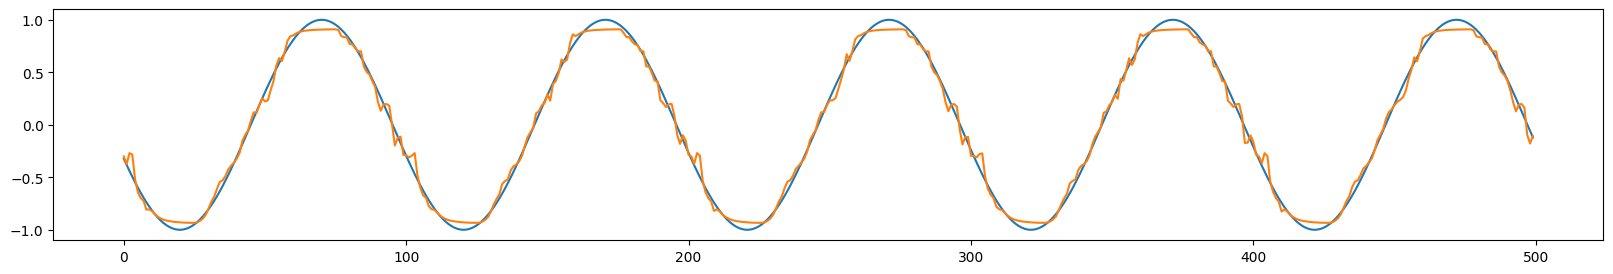

In [25]:
from matplotlib import pyplot as plt
plt.figure(figsize=(20,3))
plt.plot(groundtruth[:500])
plt.plot(predicted[:500])

# Autoregressive Evaluation (Predicting next state based on own prediction history)

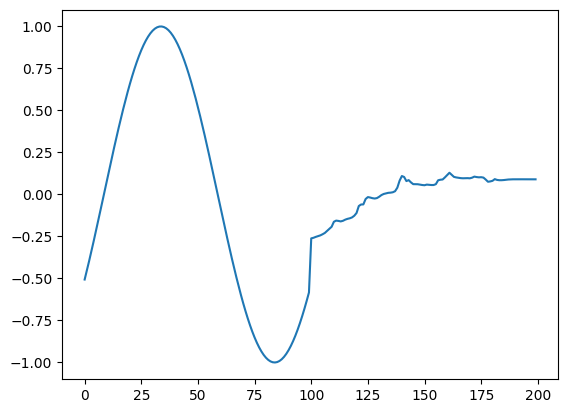

In [40]:
ar_dataset = TimeSeriesDataset(test_data, seq_length=100)

warmup = ar_dataset[0][0].unsqueeze(0)
autoregressive_forecast = forecaster.autoregress(warmup, steps=100)

plt.plot(warmup[0, :, 0, 0, 0, 0].tolist() + autoregressive_forecast[0, :, 0, 0, 0, 0].tolist())